### First of all, let's import all the necessary libraries for the first part:

In [8]:
# As Tripadvisor is a dynamic website, as a result, Selenium will be used for such kind of scraping (with help of BeautifulSoup)
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
# To avoid errors it is of paramount importance to utilize exception statements
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import ElementClickInterceptedException
from time import sleep
from bs4 import BeautifulSoup
import pandas as pd # It will be used to represent all the collected data from Tripadvisor
from datetime import datetime # It might be interesting to measure the scraping time (all in all, over 6000 reviews for Moscow Metro)

### Web scraping through Selenium and BeautifulSoup:

In [9]:
s = Service("C:/Users/Пользователь/Desktop/ChromeWebdriver/chromedriver")
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--disable-notifications")
# If necessary, other arguments can be added, for example:
# chrome_options.add_argument("--headless")
browser = webdriver.Chrome(service = s, options = chrome_options)
browser.maximize_window()
browser.get("https://www.tripadvisor.com/ShowUserReviews-g298484-d300623-r826069995-Moscow_Metro-Moscow_Central_Russia.html")

# There will be 4 collected segments:
Headlines = [] # Review title
Content = [] # Review text
Rating = [] # Evaluation (the number of bubbles, 1-5 grade)
Timeframe = [] # Publication date

page = browser.page_source
soup = BeautifulSoup(page)
start = datetime.now() # Timer's launch

# I am going to scrape all the reviews with regard to Moscow Metro in English.
# On February 14, 2022 there are 6186 reviews in English for Moscow Metro.

for title in soup.find_all("h1", class_ = "title"):
    Headlines.append(title.get_text().strip())
for body in soup.find_all("div", class_ = "ui_column is-10-desktop is-12-tablet is-12-mobile"):
    Content.append(body.find("div", class_ = "entry").get_text().strip())
for grade in soup.find_all("div", class_ = "ui_column is-10-desktop is-12-tablet is-12-mobile"):
    Rating.append(grade.find("span").get("class")[1])
for date in soup.find_all("div", {"id": {"review_826069995"}}):
    Timeframe.append(date.find("div", class_ = "prw_rup prw_reviews_stay_date_hsx").get_text().strip())

while True:
    try:
        browser.implicitly_wait(10)
        WebDriverWait(browser, 30).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "#taplc_location_reviews_list_resp_sur_a_responsive_0 > div > div:nth-child(10) > div > div > a.nav.next.ui_button.primary")
        ))
        page = browser.page_source
        soup = BeautifulSoup(page)
        for title in soup.find_all("div", class_ = "listContainer")[0].find_all("div", class_ = "review-container"):
            Headlines.append(title.find("div", class_ = "quote").get_text().strip())
        for body in soup.find_all("div", class_ = "listContainer")[0].find_all("div", class_ = "review-container"):
            Content.append(body.find("div", class_ = "entry").get_text().strip())
        for grade in soup.find_all("div", class_ = "listContainer")[0].find_all("div", class_ = "review-container"):
            Rating.append(grade.find("div", class_ = "ui_column is-9").find("span").get("class")[1])
        for date in soup.find_all("div", class_ = "listContainer")[0].find_all("div", class_ = "review-container"):
            Timeframe.append(date.find("span", class_ = "ratingDate").get("title"))
        next_page = browser.find_element(By.CSS_SELECTOR, "#taplc_location_reviews_list_resp_sur_a_responsive_0 > div > div:nth-child(10) > div > div > a.nav.next.ui_button.primary")
        next_page.click()
        sleep(7)
    
    except NoSuchElementException:
        print("NoSuchElement!")
        break
    except TimeoutException:
        print("Timeout!")
        break
    except ElementClickInterceptedException:
        print("Intercepted!")
        break
        
print(f"The total scraping time: {datetime.now() - start}")

Intercepted!
The total scraping time: 2:09:04.808121


### Some data cleaning and uploading the file, using Pandas:

In [10]:
Rating = list(map(lambda y: y.lstrip("bubble_"), Rating))
Rating = list(map(lambda x: x.rstrip("0"), Rating))
Timeframe = list(map(lambda j: j.replace("Date of experience:", ""), Timeframe))
    
Database = list(zip(Headlines, Content, Rating, Timeframe))
with open(r"Moscow_Metro_reviews.txt", mode = "w", encoding = "utf-8") as file:
    for i, j, x, y in Database:
        file.write(i + ";" + j + ";" + x + ";" + y + "\n")


columns = ["Headline", "Content/Review", "Rating", "Timeframe"]
df = pd.read_csv("Moscow_Metro_reviews.txt", delimiter = ";", names = columns)
df

,Headline,Content/Review,Rating,Timeframe
0,Best Metro in the world!,"Fast, cheap, one train every minute and it bri...",5,January 2022
1,always running on time,You can guarantee the metro will show when the...,5,"January 26, 2022"
2,state of art,You will be surprised to see some of the Mosco...,5,"January 5, 2022"
3,Good transportation,For first time I go to Moscow I went to metro ...,5,"December 26, 2021"
4,Most beautiful metro,"The Moscow metro is famous, and there is a rea...",5,"September 21, 2021"
...,...,...,...,...
6181,"Crowded, unfriendly service, no signs in Engli...",Perhaps some of the metro stations are worth a...,2,"September 5, 2008"
6182,Easy to use and has beautiful stations,If you go to Moscow be sure to take the Metro....,4,"June 30, 2008"
6183,Each Station is its own work of art,The Moscow Metro has been undergoing a lengthy...,3,"March 23, 2008"
6184,A truly unique Moscow experience!,By traveling from station to station in the ce...,5,"September 29, 2007"


In [1]:
import pandas as pd

columns = ["Headline", "Review", "Rating", "Timeframe"]
df = pd.read_csv("Moscow_Metro_reviews.txt", delimiter = ";", names = columns)
df.shape[0] # All in all, 6186 reviews.

6186

In [2]:
df.drop_duplicates(inplace=True) # To be sure there are no duplicates
df.shape[0] # There are no duplicates

6186

In [3]:
# There are some errors, pertaining to the data confusion, so we eradicate bad lines
df = df[df["Rating"].apply(pd.to_numeric, errors='coerce').notna()].dropna()
df1 = df.copy()
df.shape[0] # 180 bad lines were dropped

6006

In [4]:
# Given the substantial volume of reviews, the entire text is concealed. We can check the quality of reviews.
pd.set_option("display.max_colwidth", None)
df.head()

,Headline,Review,Rating,Timeframe
0,Best Metro in the world!,"Fast, cheap, one train every minute and it brings you anywhere you need in the city. Never expereinced any better metro in the world.",5,January 2022
1,always running on time,You can guarantee the metro will show when they say. The subways are pristine and quite. I love the people. No one screaming or speaking loudly anywhere. You could whisper to friends and still hear each other.,5,"January 26, 2022"
2,state of art,"You will be surprised to see some of the Moscow metro stations. More like a museum with amazing architecture. Long impressive escalators, not overcrowded trains (unless middle of rush hour), very well priced with the troyka card.If you have been in crowded, small, dirty metro of New-York, London, etc... you will be positively surprised in Moscow!",5,"January 5, 2022"
3,Good transportation,For first time I go to Moscow I went to metro station it was at winter and a lot of snow it was very good and clean and fast at the specific time,5,"December 26, 2021"
4,Most beautiful metro,"The Moscow metro is famous, and there is a reason:many stations are very beautifully designed, so is worth to stop and admire the design. I did the circle tour and stopped at several stations which were all very beautiful. Highly recommended when you visit the city!",5,"September 21, 2021"


In [5]:
# To process all the information in a fast manner let's conceal the the whole values
pd.reset_option("display.max_colwidth")
df.head()

,Headline,Review,Rating,Timeframe
0,Best Metro in the world!,"Fast, cheap, one train every minute and it bri...",5,January 2022
1,always running on time,You can guarantee the metro will show when the...,5,"January 26, 2022"
2,state of art,You will be surprised to see some of the Mosco...,5,"January 5, 2022"
3,Good transportation,For first time I go to Moscow I went to metro ...,5,"December 26, 2021"
4,Most beautiful metro,"The Moscow metro is famous, and there is a rea...",5,"September 21, 2021"


Text(0.5, 0.98, "Sentiment distribution among users \nof Tripadvisor in the category 'Moscow Metro'")

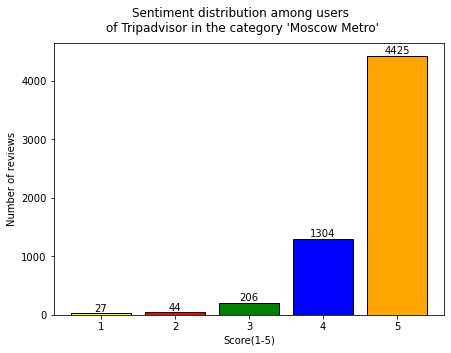

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

# Visualization of sentiment grades(1-5)
review_data = df.groupby("Rating")["Review"].count().reset_index()
fig, axes = plt.subplots(1, figsize=(7, 5))
axes.bar(review_data["Rating"], review_data["Review"], 
         color=["yellow", "red", "green", "blue", "orange"],
        edgecolor = "black")

def labels_on_top(i, j):
    for values in range(len(i)):
        plt.text(values ,j[values] + 30, j[values], ha = "center")
        
labels_on_top(review_data["Rating"], review_data["Review"])
axes.set_xlabel("Score(1-5)")
axes.set_ylabel("Number of reviews")
fig.suptitle("Sentiment distribution among users \nof Tripadvisor in the category 'Moscow Metro'")

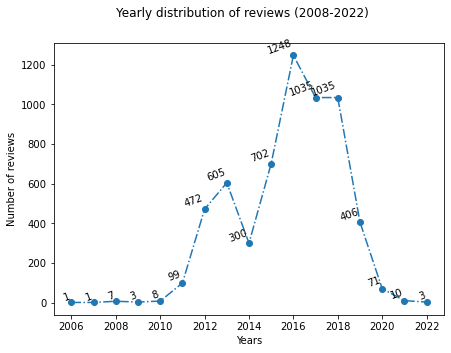

In [7]:
import numpy as np
# Visualization of the reviews' amount on an annual basis
years = list(range(2006, 2023))
reviews_per_year = []
for i in range(2006, 2023):
    reviews_per_year.append(df[df.Timeframe.str.contains(str(i))].shape[0])
fig, axes = plt.subplots(1, figsize=(7, 5))
axes.plot(years, reviews_per_year, linestyle="-.", marker = "o")
axes.set_xlabel("Years")
axes.set_ylabel("Number of reviews")
fig.suptitle("Yearly distribution of reviews (2008-2022)")
for i, j in enumerate(reviews_per_year):
    axes.annotate(j, (years[i], reviews_per_year[i] + 10), rotation = 20, ha="right", fontsize=10)

### Preprocessing stage: 

In [8]:
from nltk.corpus import stopwords # To eliminate all superfluous stopwords from the text (headlines and text)
from nltk.tokenize import word_tokenize # To split the text into words

stop_words = stopwords.words("English")
df["Review"] = df["Review"].apply(lambda x: " ".join([token for token in word_tokenize(x) if token not in stop_words]))
df["Headline"] = df["Headline"].apply(lambda y: " ".join([token for token in word_tokenize(y) if token not in stop_words]))
df.head() # Stopwords are eliminated

,Headline,Review,Rating,Timeframe
0,Best Metro world !,"Fast , cheap , one train every minute brings a...",5,January 2022
1,always running time,You guarantee metro show say . The subways pri...,5,"January 26, 2022"
2,state art,You surprised see Moscow metro stations . More...,5,"January 5, 2022"
3,Good transportation,For first time I go Moscow I went metro statio...,5,"December 26, 2021"
4,Most beautiful metro,"The Moscow metro famous , reason : many statio...",5,"September 21, 2021"


In [9]:
# Elimination of punctuation marks
import string
punctuation_marks = string.punctuation
df["Review"] = df["Review"].apply(lambda x: " ".join([token for token in word_tokenize(x) if token not in punctuation_marks]))
df["Headline"] = df["Headline"].apply(lambda y: " ".join([token for token in word_tokenize(y) if token not in punctuation_marks]))
df.head()

,Headline,Review,Rating,Timeframe
0,Best Metro world,Fast cheap one train every minute brings anywh...,5,January 2022
1,always running time,You guarantee metro show say The subways prist...,5,"January 26, 2022"
2,state art,You surprised see Moscow metro stations More l...,5,"January 5, 2022"
3,Good transportation,For first time I go Moscow I went metro statio...,5,"December 26, 2021"
4,Most beautiful metro,The Moscow metro famous reason many stations b...,5,"September 21, 2021"


In [10]:
# Lowercase text transformation
df["Review"] = df["Review"].apply(lambda x: x.lower())
df["Headline"] = df["Headline"].apply(lambda y: y.lower())
df.head()

,Headline,Review,Rating,Timeframe
0,best metro world,fast cheap one train every minute brings anywh...,5,January 2022
1,always running time,you guarantee metro show say the subways prist...,5,"January 26, 2022"
2,state art,you surprised see moscow metro stations more l...,5,"January 5, 2022"
3,good transportation,for first time i go moscow i went metro statio...,5,"December 26, 2021"
4,most beautiful metro,the moscow metro famous reason many stations b...,5,"September 21, 2021"


In [11]:
# It is necessary to implement lemmatization for grouping together the different inflected forms of words
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatization(j):
    if j.startswith("N"):
        return wordnet.NOUN
    elif j.startswith("V"):
        return wordnet.VERB
    elif j.startswith("J"):
        return wordnet.ADJ
    elif j.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

df["Review"] = df["Review"].apply(lambda x: " ".join([lemmatizer.lemmatize(i[0], lemmatization(i[1])) for i in nltk.pos_tag(word_tokenize(x))]))
df["Headline"] = df["Headline"].apply(lambda y: " ".join([lemmatizer.lemmatize(i[0], lemmatization(i[1])) for i in nltk.pos_tag(word_tokenize(y))]))
df.head()

,Headline,Review,Rating,Timeframe
0,best metro world,fast cheap one train every minute bring anywhe...,5,January 2022
1,always run time,you guarantee metro show say the subway pristi...,5,"January 26, 2022"
2,state art,you surprise see moscow metro station more lik...,5,"January 5, 2022"
3,good transportation,for first time i go moscow i go metro station ...,5,"December 26, 2021"
4,most beautiful metro,the moscow metro famous reason many station be...,5,"September 21, 2021"


### Word Cloud for positive headlines and reviews (Rating >=  3)

In [12]:
df["Rating"] = df["Rating"].astype("int")
df_positive = df.query("Rating >= 3")
df_positive.shape[0] # All in all, 5935 positive reviews

5935

<function matplotlib.pyplot.show(close=None, block=None)>

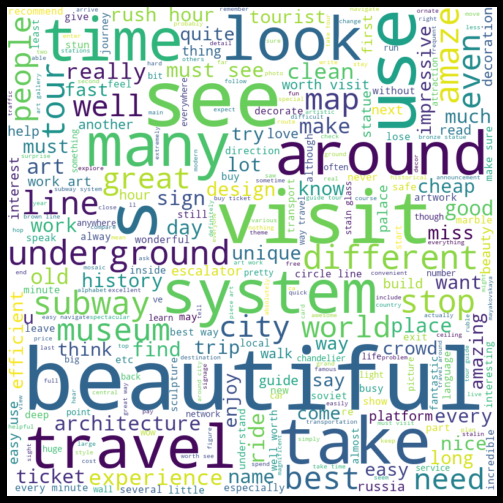

In [13]:
from wordcloud import WordCloud, STOPWORDS

pos_review = " ".join([i for i in df_positive["Review"]])
pos_headline = " ".join([j for j in df_positive["Headline"]])
pos_content = pos_review + " " + pos_headline

stopwords = STOPWORDS
# For more interesting results let's add evident popular words and some reduntant marks
stopwords.update(["metro", "station", "moscow", "one", "n't", "’", "...", "'s", "train", "go", "russian", "english"])

wc = WordCloud(
    background_color = "white",
    max_words = 300,
    height = 800,
    width = 800,
    stopwords = stopwords
)
wc.generate(pos_content)
plt.figure(figsize=(16, 9), facecolor="k")
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show

### Word Cloud for negative headlines and reviews (Rating <= 2)

In [14]:
df_negative = df.query("Rating <= 2")
df_negative.shape[0] # All in all, 71 negative reviews

71

<function matplotlib.pyplot.show(close=None, block=None)>

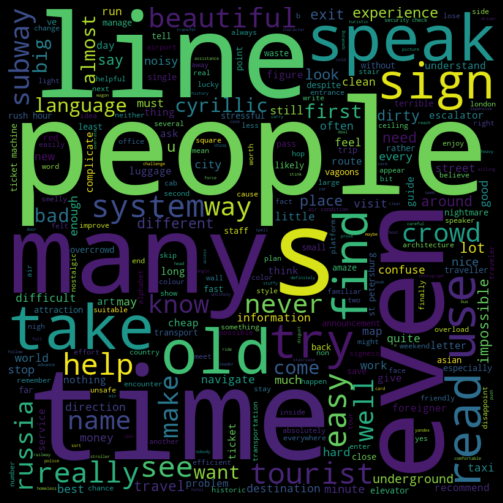

In [15]:
neg_review = " ".join([i for i in df_negative["Review"]])
neg_headline = " ".join([j for j in df_negative["Headline"]])
neg_content = neg_review + " " + neg_headline

wc = WordCloud(
    background_color = "black",
    max_words = 300,
    height = 800,
    width = 800,
    stopwords = stopwords
)
wc.generate(neg_content)
plt.figure(figsize=(16, 9), facecolor="k")
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show

In [16]:
from nltk.probability import FreqDist

pos_list = FreqDist([token for token in word_tokenize(pos_content) if token not in stopwords])
pos_list.most_common(10) # Major posiive words

[('see', 2282),
 ('beautiful', 2209),
 ('visit', 1803),
 ('take', 1695),
 ('line', 1569),
 ('use', 1517),
 ('art', 1461),
 ('time', 1447),
 ('way', 1298),
 ('system', 1274)]

In [17]:
neg_list = FreqDist([token for token in word_tokenize(neg_content) if token not in stopwords])
neg_list.most_common(10) # Major negative words

[('people', 30),
 ('time', 28),
 ('even', 22),
 ('line', 22),
 ('many', 20),
 ('old', 18),
 ('take', 18),
 ('speak', 18),
 ('try', 17),
 ('use', 17)]

In [18]:
df.head()

,Headline,Review,Rating,Timeframe
0,best metro world,fast cheap one train every minute bring anywhe...,5,January 2022
1,always run time,you guarantee metro show say the subway pristi...,5,"January 26, 2022"
2,state art,you surprise see moscow metro station more lik...,5,"January 5, 2022"
3,good transportation,for first time i go moscow i go metro station ...,5,"December 26, 2021"
4,most beautiful metro,the moscow metro famous reason many station be...,5,"September 21, 2021"


### Comparison of three NLP libraries: TextBlob, NLTK and Flair

In [19]:
pd.reset_option("display.max_colwidth")
def rating_sentiment(y):
    if y >= 3: # positive: grades 5, 4, 3
        return "positive"
    else: # negative: grades 2, 1
        return "negative"

df.set_index("Headline")
df_sentiment = df.copy()
df_sentiment.drop(["Timeframe"], axis=1, inplace=True)
# We are going to express the rating grade as a string ("positive"/"negative") for better human understanding
df_sentiment["Rating_sentiment"] = df_sentiment["Rating"].apply(rating_sentiment)
df_sentiment.head()

,Headline,Review,Rating,Rating_sentiment
0,best metro world,fast cheap one train every minute bring anywhe...,5,positive
1,always run time,you guarantee metro show say the subway pristi...,5,positive
2,state art,you surprise see moscow metro station more lik...,5,positive
3,good transportation,for first time i go moscow i go metro station ...,5,positive
4,most beautiful metro,the moscow metro famous reason many station be...,5,positive


In [20]:
# Let's import three NLP libraries for the purpose of carrying out the sentiment analysis of reviews.
# And after that let's compare the feedback from three NLP libraries with the official rating sentiment
# 1. First of all, we are going to utilize TextBlob and measure the accuracy
from textblob.sentiments import PatternAnalyzer

pa = PatternAnalyzer()

def textblob_analyze(i):
    if pa.analyze(i)[0] > 0:
        return "positive"
    else:
        return "negative"
df_sentiment["Textblob_sentiment"] = df_sentiment["Review"].apply(textblob_analyze)
df_sentiment.head()

,Headline,Review,Rating,Rating_sentiment,Textblob_sentiment
0,best metro world,fast cheap one train every minute bring anywhe...,5,positive,positive
1,always run time,you guarantee metro show say the subway pristi...,5,positive,positive
2,state art,you surprise see moscow metro station more lik...,5,positive,positive
3,good transportation,for first time i go moscow i go metro station ...,5,positive,positive
4,most beautiful metro,the moscow metro famous reason many station be...,5,positive,positive


In [21]:
# Let's compare two Pandas series and figure out the accuracy of TextBlob
df_sentiment["Rating_sentiment"].compare(df_sentiment["Textblob_sentiment"]).shape[0]
# There are 464 discrepancies out of 6006 results.

464

In [22]:
# Let's find out the accuracy score, using sklearn
from sklearn.metrics import accuracy_score

score_textblob = accuracy_score(df_sentiment["Rating_sentiment"].tolist(), df_sentiment["Textblob_sentiment"].tolist())
score_textblob

0.9227439227439227

In [23]:
# 2. Secondly, we are going to utilize NLTK and measure the accuracy as well
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

def nltk_analyze(i):
    if vader.polarity_scores(i)["compound"] > 0:
        return "positive"
    else:
        return "negative"
df_sentiment["NLTK_sentiment"] = df_sentiment["Review"].apply(nltk_analyze)
df_sentiment.head()

,Headline,Review,Rating,Rating_sentiment,Textblob_sentiment,NLTK_sentiment
0,best metro world,fast cheap one train every minute bring anywhe...,5,positive,positive,negative
1,always run time,you guarantee metro show say the subway pristi...,5,positive,positive,positive
2,state art,you surprise see moscow metro station more lik...,5,positive,positive,positive
3,good transportation,for first time i go moscow i go metro station ...,5,positive,positive,positive
4,most beautiful metro,the moscow metro famous reason many station be...,5,positive,positive,positive


In [24]:
# Let's compare two Pandas series and figure out the accuracy of NLTK
df_sentiment["Rating_sentiment"].compare(df_sentiment["NLTK_sentiment"]).shape[0]
# There are 475 discrepancies out of 6006 results.

475

In [25]:
# And finally we are going to find out the accuracy score, using sklearn
score_nltk = accuracy_score(df_sentiment["Rating_sentiment"].tolist(), df_sentiment["NLTK_sentiment"].tolist())
score_nltk

0.9209124209124209

In [26]:
import flair 

flair_sentiment = flair.models.TextClassifier.load("en-sentiment")

def flair_analyze(k):
    s = flair.data.Sentence(k)
    flair_sentiment.predict(s)
    if s.labels[0].value == "POSITIVE":
        return "positive"
    else:
        return "negative"

df_sentiment["Flair_sentiment"] = df_sentiment["Review"].apply(flair_analyze)
df_sentiment.head()

2022-03-11 22:01:12,998 loading file C:\Users\Пользователь\.flair\models\sentiment-en-mix-distillbert_4.pt


,Headline,Review,Rating,Rating_sentiment,Textblob_sentiment,NLTK_sentiment,Flair_sentiment
0,best metro world,fast cheap one train every minute bring anywhe...,5,positive,positive,negative,positive
1,always run time,you guarantee metro show say the subway pristi...,5,positive,positive,positive,positive
2,state art,you surprise see moscow metro station more lik...,5,positive,positive,positive,positive
3,good transportation,for first time i go moscow i go metro station ...,5,positive,positive,positive,positive
4,most beautiful metro,the moscow metro famous reason many station be...,5,positive,positive,positive,positive


In [27]:
# Let's compare two Pandas series and figure out the accuracy of Flair
df_sentiment["Rating_sentiment"].compare(df_sentiment["Flair_sentiment"]).shape[0]
# There are 1113 discrepancies out of 6006 results.

1113

In [28]:
# And finally we are going to find out the accuracy score, using sklearn
score_flair = accuracy_score(df_sentiment["Rating_sentiment"].tolist(), df_sentiment["Flair_sentiment"].tolist())
score_flair

0.8146853146853147

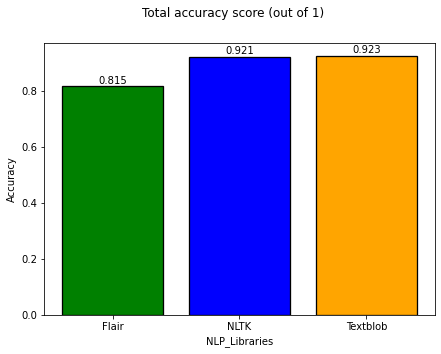

In [29]:
# Visualization of accuracy scores across three NLP-libraries (Textblob, NLTK and Flair)

scores = [score_flair, score_nltk, score_textblob]
scores = list(map(lambda y: float(format(y, ".3f")), scores))
nlp_libraries = ["Flair", "NLTK", "Textblob"]

fig, axes = plt.subplots(1, figsize = (7, 5))
axes.bar(nlp_libraries, scores, color = ["green", "blue", "orange"], edgecolor = "black", linewidth = 1.3)
axes.set_xlabel("NLP_Libraries")
axes.set_ylabel("Accuracy")
fig.suptitle("Total accuracy score (out of 1)")

def labels_on_top(i, j):
    for values in range(len(i)):
        plt.text(values ,j[values] + 0.01, j[values], ha = "center")       
labels_on_top(nlp_libraries, scores)

In [30]:
# Taking into account the fact that the Textblob library is the most accurate one, 
# let's use it to find out 5 the most positive and the most negative reviews:
pd.set_option("display.max_colwidth", None)

def textblob_analyze(i):
    return pa.analyze(i)[0]

df1["Textblob_sentiment"] = df1["Review"].apply(textblob_analyze)
df1.head()

,Headline,Review,Rating,Timeframe,Textblob_sentiment
0,Best Metro in the world!,"Fast, cheap, one train every minute and it brings you anywhere you need in the city. Never expereinced any better metro in the world.",5,January 2022,0.366667
1,always running on time,You can guarantee the metro will show when they say. The subways are pristine and quite. I love the people. No one screaming or speaking loudly anywhere. You could whisper to friends and still hear each other.,5,"January 26, 2022",0.158333
2,state of art,"You will be surprised to see some of the Moscow metro stations. More like a museum with amazing architecture. Long impressive escalators, not overcrowded trains (unless middle of rush hour), very well priced with the troyka card.If you have been in crowded, small, dirty metro of New-York, London, etc... you will be positively surprised in Moscow!",5,"January 5, 2022",0.162500
3,Good transportation,For first time I go to Moscow I went to metro station it was at winter and a lot of snow it was very good and clean and fast at the specific time,5,"December 26, 2021",0.345333
4,Most beautiful metro,"The Moscow metro is famous, and there is a reason:many stations are very beautifully designed, so is worth to stop and admire the design. I did the circle tour and stopped at several stations which were all very beautiful. Highly recommended when you visit the city!",5,"September 21, 2021",0.500000


In [31]:
df1.nlargest(5, "Textblob_sentiment") # 5 the most positive reviews (with the highest grade) according to
# the TextBlob library

,Headline,Review,Rating,Timeframe,Textblob_sentiment
220,"Train stations as a tourist attraction?""","I had never thought of railway stations as a tourist attraction until I saw the Moscow Metro. The artwork, sculpture and architecture are magnificent over the half-dozen stations that I visited. Also the cleanliness was a feature.",5,"August 6, 2019",1.0
915,Ther most amazing metro system I have seen,Buy a trip card and just travel around. No need to book a tour. Exceeded what I was expecting.Plenty of info online as well as to the 'best' stations,5,"August 11, 2018",1.0
1114,Excellent,"This is the best metro station I have ever been to. It has history, class, character. It resembles Russia today, and during the days is the Soviet union.",5,"July 5, 2018",1.0
1217,A must,Take some Stopp during your visit!!! Like a museum!!! Best you take a Lokal guide to show you the very best,5,"June 17, 2018",1.0
1267,Beautiful!,The metro system in Moscow is superb! the architecture is something to be seen yourself - out of this world.,5,"June 1, 2018",1.0


In [32]:
df1.nsmallest(5, "Textblob_sentiment") 
# 5 the most negative reviews (with the highest grade) according to the TextBlob library
# Strangely enough, among them are some reviews with 5 grades (apparently due to some negative keywords)

,Headline,Review,Rating,Timeframe,Textblob_sentiment
565,Incredible,We did not visit all stations but the ones we did see were just amazing...almost art galleries... must drive the locals crazy with the tourists stopping to take in the art,5,"November 9, 2018",-0.600000
3062,Several stations are very interesting!,"Some stations are especially worse seeing! Visit Maiakovskaia, Kropotkinskaia, Novoslobodskaia, Dostoevskaia! And some other.",5,"August 24, 2016",-0.562500
2353,Very old,But u can see all nations from over the world. It feels like u r still in ussr periodsuch nostalgic.. it reminds childhood in 90th,3,"April 28, 2017",-0.500000
3283,great metro system,the cleanest fastest metro system that can take you anywhere. the only bad bad thing is that inside of the actualy train is a bit loud and gets u sick when ure tired.,5,"July 17, 2016",-0.402381
2436,Confusion,Download yandex.metro - it will help you to plan your route and calculate even time to reach the destination. But in reality in centre everything is so confused and nobody can give you a correct answer. Sometimes I was misleading and felt claustrophobia cause ceiling is low and rush hour. Prefer to take taxi. Bad experience.,2,"March 26, 2017",-0.366667
